# Experiment 2

The goal of the experiment was to learn a simple reference game between a sender and a receiver. The sender is trained using policy gradients and the receiver using supervised learning. Well-defined codebooks for both the sender and the receiver emerge.

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.optim import Adam
import seaborn as sns; sns.set()

torch.manual_seed(1773)
sns.set(rc={'figure.figsize':(15,20)})

In [3]:
class SenderPolicyNet(nn.Module):
    def __init__(self, input_size, alphabet_size):
        super().__init__()
        self.linear = nn.Embedding(input_size, alphabet_size)

    def forward(self, input):
        return F.softmax(self.linear(input), dim=1)
    
class ReceiverNet(nn.Module):
    def __init__(self, alphabet_size, output_size):
        super().__init__()
        self.linear = nn.Embedding(alphabet_size, output_size)

    def forward(self, input):
        return F.softmax(self.linear(input), dim=1)

In [4]:
class DifferentiableWorld:
    def __init__(self, batch_size, world_size):
        self.batch_size, self.world_size = batch_size, world_size
        self.reset()
    
    def reset(self):
        self.hidden_state = torch.randint(
            high=self.world_size, 
            size=(self.batch_size,),
            dtype=torch.long
        )
    
    def receive_observation(self):
        return self.hidden_state
    
    def evaluate_prediction(self, pred):
        return F.nll_loss(pred, self.hidden_state)

In [5]:
class Sender:
    
    def __init__(self, input_size, alphabet_size, learning_rate):
        self.policy = SenderPolicyNet(input_size=input_size, alphabet_size=alphabet_size)
        self.optimizer = Adam(params=self.policy.parameters(), lr=learning_rate, weight_decay=0.000001)
          
    def send_message(self, input):
        probs = self.policy(input)
        distribution = Categorical(probs)
        action = distribution.sample()
        self.last_action_probs, self.last_action = distribution.log_prob(action), action
        return action
    
    def teach(self, rewards):
        self.optimizer.zero_grad()  
        loss = -(self.last_action_probs * rewards).sum()
        loss.backward()
        self.optimizer.step()
        return loss
    
class Receiver:
    
    def __init__(self, alphabet_size, output_size, learning_rate):
        self.policy = ReceiverNet(alphabet_size, output_size)
        self.optimizer = Adam(params=self.policy.parameters(), lr=learning_rate, weight_decay=0.000001)
          
    def predict(self, message):
        self.received_message = message
        return self.policy(message)
    
    def teach(self, loss):
        self.optimizer.zero_grad()  
        loss.backward()
        self.optimizer.step()
        return self.policy.linear.weight.grad
    
sender = Sender(10, 25, learning_rate=0.1)
receiver = Receiver(25, 10, learning_rate=0.1)
world = DifferentiableWorld(10, 10)
for epoch in range(10000):
    observation = world.receive_observation()
    message = sender.send_message(observation)
    prediction = receiver.predict(message)
    loss = world.evaluate_prediction(prediction)
    rewards = receiver.teach(loss)
    sender.teach(rewards[message])
    world.reset()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, loss {loss:.2f}')
        print(observation, message, prediction.argmax(dim=1))

Epoch 0, loss -0.11
tensor([2, 8, 5, 6, 4, 2, 4, 1, 4, 6]) tensor([ 6, 24, 14, 17, 22,  1,  3,  4, 15,  8]) tensor([6, 0, 3, 9, 0, 2, 5, 0, 3, 7])
Epoch 100, loss -0.23
tensor([5, 5, 5, 5, 0, 4, 4, 1, 0, 1]) tensor([ 1, 23, 19,  1,  6,  1,  8, 13, 21, 17]) tensor([4, 2, 5, 4, 2, 4, 7, 6, 3, 2])
Epoch 200, loss -0.40
tensor([3, 5, 9, 4, 8, 5, 5, 5, 0, 2]) tensor([17, 15,  0, 11,  0,  1, 23, 19, 15, 12]) tensor([2, 3, 9, 4, 9, 4, 3, 5, 3, 2])
Epoch 300, loss -0.30
tensor([6, 6, 0, 3, 2, 1, 8, 3, 0, 8]) tensor([13, 13, 24, 13, 12, 22,  0, 17, 24, 19]) tensor([6, 6, 3, 6, 2, 8, 9, 2, 3, 5])
Epoch 400, loss -0.60
tensor([1, 5, 1, 8, 8, 7, 8, 4, 1, 5]) tensor([ 4, 19, 13, 22, 18, 24, 22, 20,  7, 19]) tensor([1, 5, 6, 8, 0, 3, 8, 4, 8, 5])
Epoch 500, loss -0.40
tensor([2, 4, 9, 5, 7, 0, 4, 4, 1, 8]) tensor([12, 20, 14,  1, 24,  7, 11, 18,  8,  9]) tensor([2, 4, 7, 4, 3, 8, 4, 0, 7, 8])
Epoch 600, loss -0.50
tensor([8, 0, 2, 3, 2, 8, 4, 3, 1, 5]) tensor([ 7, 18, 21, 12, 12,  9, 11, 12,  4, 13]

In [6]:
def visualize_codebook(agent):
    sns.heatmap(F.softmax(agent.policy.linear.weight, dim=1).detach().numpy(), annot=True, fmt='.1f')

A injective function from world states to alphabet


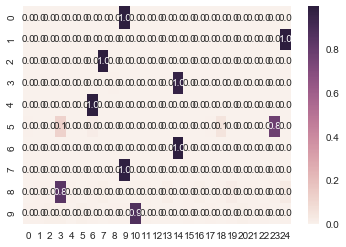

In [7]:
visualize_codebook(sender)
print('A injective function from world states to alphabet')

A surjective function from alphabet to world states


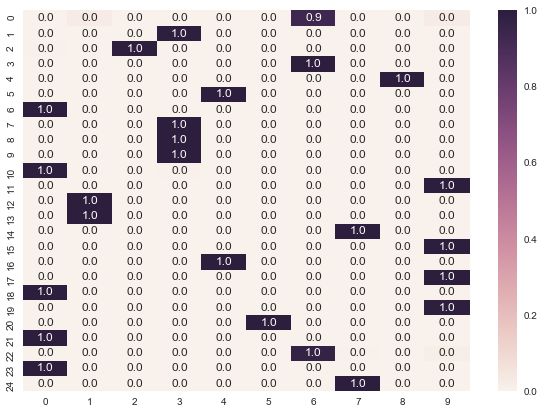

In [61]:
visualize_codebook(receiver)
print('A surjective function from alphabet to world states')

The encoder (sender's codebook) as a function $e$ is the inverse of decoder $d$ (receiver's codebook), i.e. $e = d^{-1}$ and $e \circ d = id$ (modulo the non-linearity). This can be seen by applying Moore-Penrose pseudoinverse to receiver's weights and comapring it to the transpose of receiver's weights.

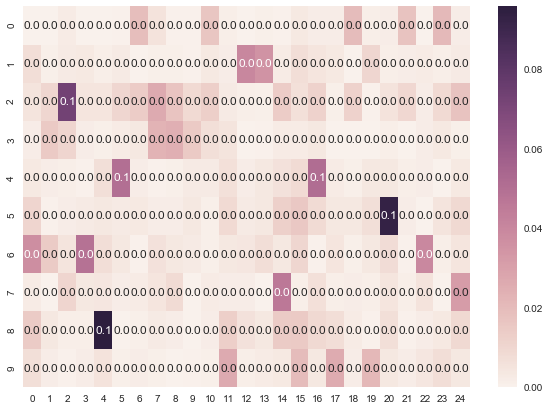

In [62]:
sns.heatmap(torch.abs(receiver.policy.linear.weight.pinverse()).detach().numpy(), annot=True, fmt='.1f')

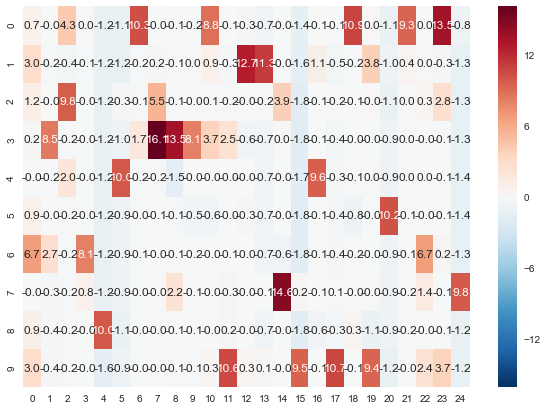

In [64]:
sns.heatmap(receiver.policy.linear.weight.transpose(dim0=0, dim1=1).detach().numpy(), annot=True, fmt='.1f')